**Welcome to the fourth programming assignment for CS 498 RL!**

This assignment will get you familiar with value function approximation and actor-critic algorithm. You need to write your code from scratch and explore the good hyperparameters. The question is inspired/borrowed from Philip Thomas's course.

You only need to report your result for one trial/run. There is some randomness in the environment, so you don't need to expect the result of every trial can meet the expectation. But make sure that you can get similar (high return) results with the same hyperparameters in general. For grading, we will not only look at your figure, but may also run your code and see whether we can reproduce similar (high return) results. That said, we may later request your notebook file if needed, though you don't need to submit them now. You will receive partial credit if your result is mostly due to randomness. We may also use our hyperparameters to test your code. If your result does not meet the expecation because of the hyperparameters but your implementation is correct, you will receive partial credit.

Make sure your submitted version contain the final results (figures). If not, you will only get partial credit.

In [ ]:
import gym
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

We will be playing on the Cartpole environment. As the title suggests, the task in this environment is to balance a pole on top of a cart. The official description of the environment from the OpenAI Gym website (https://gym.openai.com/) is:

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. CartPole-v1 defines "solving" as getting average reward of 475.0 over 500 consecutive trials. This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson [Barto83].

In the environment, the actions are dicrete and indexed as 0, 1. The state space is a 4 dimension continuous space. In all the following, the trajectory is $\tau=(s_0,a_0,r_0,s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

More information can be found on the following wiki page: https://gym.openai.com/envs/CartPole-v1/

**Q1: Implement the TD actor-critic algorithm using the Fourier basis as linear approximation component**.

Write a method called actor_critic_TD(gamma, alpha_actor, alpha_critic, n_actor, n_critic, num_epi), which implements the TD actor-critic with discount factor $\gamma$, learning rate $\alpha_{actor}$, $\alpha_{critic}$, and runs for num_epi episodes. $n_{actor}$ and $n_{critic}$ are the orders of Fourior basis for the actor and the critic respectively.

The critic learns a state-value function $V(s)$ and the update of critic is TD(0): $\delta_t = r_t + \gamma  w^\top \phi_{critic}(s_{t+1})-w^\top \phi_{critic}(s_t)$ and $w_{t+1}=w_t+\alpha_{critic}\gamma^t\delta_t \phi_{critic}(s_t)$, where $\phi_{critic}(s_t)$ is the Fourier basis features for critic and $w_t$ is the weights. The initial weights are set to 0. You should use the same learning rate $\alpha_{critic}$ for all the features and you don't need to sacle it according to the reference.

The actor $\pi_\theta$ is parameterized as $\pi_\theta(a|s)\propto \exp(\theta^\top \phi_{actor}(s,a))$ and the update of actor is $\theta_{t+1}=\theta_t + \alpha_{actor} \gamma^t\delta_t\nabla_\theta \log \pi_\theta(a_t|s_t)$. Here the TD term $\delta_t$ (defined above) approximates the advantage function $A(s_t,a_t)$.

Since the Cartpole environment has the discrete action space and the continuous state space, we ask you to apply linear approximation with Fourier basis (Equation (4) in http://psthomas.com/papers/Konidaris2011a.pdf) on the state space and use tabular represenatation for the action space. Specifically, we construct $\phi_{actor}(s,a)=\psi_{actor}(s)$ according to the reference and assume $\phi_{actor}(s,a)$ to be the same for all actions, i.e. $\forall a, \phi_{actor}(s,a)=\psi_{actor}(s)$. Then, use different weight vectors for different actions. The initial weights are set to 0. You will need to figure out how to compute $\nabla_\theta \log \pi_\theta(a_t|s_t)$. You should use the same learning rate $\alpha_{actor}$ for all the features and you don't need to sacle it according to the reference.

Note that the actor and the critic can use different orders of Fourior basis, thus different features. If $s_{t+1}$ is the terminal states, set the value to 0, i.e. $w^\top \phi_{critic}(s_{t+1})=0$. In implementation, you may just replace $w^\top \phi_{critic}(s_{t+1})$ with 0.

For simplicity, we provide you with a function actor_feature which takes Fourior basis order $n_{actor}$ as input and outputs the features and weights for policy $\pi$. Also, we give you a function critic_feature which takes Fourior basis order $n_{critic}$ as input and outputs the features and weights for V-function.

Your function should return a list (with length num_epi), which consists of the smoothed undiscounted return. That's said, first calculate the undiscounted return of the current episode without discount factor $\gamma$. Then calculate the mean of undiscounted return for last 200 episodes. If there are less than 200 episodes, calculate the mean of all episodes. Notice that you may use $\gamma<1$ in your algorithm, but you need to calculate the undiscounted return.

After tuning the hyperparameters $\gamma,\alpha_{actor}, \alpha_{critic}, n_{actor}$, and $n_{critic}$, run the actor_critic_TD function for 10000 episodes and draw a figure of the smoothed undisounted return obtained from the function. The $x$-axis is the number of episodes (10000 in total) and the $y$-axis is the smoothed undisounted return.

You can use any reasonable hyperparameters. But you should expect the smoothed undisounted return can exceed than 150, though it may not increase monotonically.

If running 10000 episodes takes too long and your result can exceed 150 for many (e.g. 500) episodes, you may also report your final result with fewer episodes.

In theory to the samples to approximate the PG estimator should be under $\mathbb{E}_{d^{\pi}}$, i.e., the discounted occupancy, which means that later states in the trajectory will be discounted heavily. But in practice often undiscounted updates are used for the actor while still using discounted returnts for the critic. You may want to explore this for better performance.

<ipython-input-47-0cfe71539c11>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  select = float(np.random.uniform(0.0, 1.0, 1))


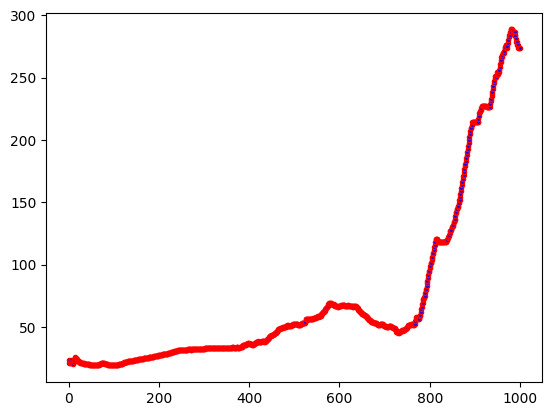

In [ ]:
env = gym.make('CartPole-v1')

def actor_feature(n_actor):
  dim_state = 4
  num_action = 2
  # Construct features for the actor
  c_actor = []
  for i in range((n_actor + 1) ** dim_state):
    index = i
    temp_c = []
    for j in range(dim_state):
      temp_c.append(index % (n_actor + 1))
      index //= n_actor + 1
    c_actor.append(temp_c)
  c_actor = np.asarray(c_actor)
  weight_actor = np.zeros(((n_actor + 1) ** dim_state, num_action))
  return c_actor, weight_actor


def critic_feature(n_critic):
  # Construct features for the critic
  dim_state = 4
  num_action = 2
  c_critic = []
  for i in range((n_critic + 1) ** dim_state):
    index = i
    temp_c = []
    for j in range(dim_state):
      temp_c.append(index % (n_critic + 1))
      index //= n_critic + 1
    c_critic.append(temp_c)
  c_critic = np.asarray(c_critic)
  weight_critic = np.zeros((n_critic + 1) ** dim_state)
  return c_critic, weight_critic

def actor_critic_TD(gamma, alpha_actor, alpha_critic, n_actor, n_critic, num_epi):
  ### Your code here
  org_returns = []
  smoothed_undiscounted_return_list = []

  ## initialize weight
  c_actor, weight_actor = actor_feature(n_actor)
  c_critic, weight_critic = critic_feature(n_critic)

  for episode in range(num_epi):
    state = env.reset()     # initialize S
    undiscounted_return = 0
    done = False
    t = 0
    while not done:

      ## select action correspond to actor
      value0_actor = weight_actor.T[0] @ np.cos(np.pi * c_actor @ state.reshape((4, 1)))
      pi0_actor = np.exp(value0_actor)
      value1_actor = weight_actor.T[1] @ np.cos(np.pi * c_actor @ state.reshape((4, 1)))
      pi1_actor = np.exp(value1_actor)
      if pi0_actor == np.inf and pi1_actor == np.inf:       # overflow happens
        pi0_actor = pi1_actor = 1
      elif pi0_actor == np.inf:
        pi0_actor = 0.9
        pi1_actor = 0.1
      elif pi1_actor == np.inf:
        pi0_actor = 0.9
        pi1_actor = 0.1
      prob0 = pi0_actor / (pi0_actor + pi1_actor)
      prob1 = pi1_actor / (pi0_actor + pi1_actor)
      select = float(np.random.uniform(0.0, 1.0, 1))
      if select < prob0:        # choose action 0
        a_t = 0
        pi_cur_actor = prob0
        value_cur_actor = value0_actor
      else:
        a_t = 1
        pi_cur_actor = prob1
        value_cur_actor = value1_actor

      ## critic: value of current state
      value_cur_critic = weight_critic.reshape(1, -1) @ np.cos(np.pi * c_critic @ state.reshape((4, 1)))

      ## take step
      next_state, reward, done, info = env.step(a_t)
      undiscounted_return += reward

      ## critic: compute delta
      if done:
        value_next_critic = 0
      else:
        value_next_critic = weight_critic.reshape(1, -1) @ np.cos(np.pi * c_critic @ next_state.reshape((4, 1)))
      delta = reward + gamma * value_next_critic - value_cur_critic

      ## critic: update weight
      weight_critic += (alpha_critic * (gamma**t) * delta * np.cos(np.pi * c_critic @ state.reshape((4, 1)))).reshape(weight_critic.shape)
      # weight_critic += (alpha_critic * delta * np.cos(np.pi * c_critic @ state.reshape((4, 1)))).reshape(weight_critic.shape)

      ## actor: update weight
      if pi_cur_actor == 0:
        weight_actor.T[a_t] += 0
      else:
        partial_log_actor = np.cos(np.pi * c_actor @ state.reshape((4, 1))) * (1 - pi_cur_actor)
        weight_actor.T[a_t] += (alpha_actor * (gamma**t) * delta * partial_log_actor).reshape(weight_actor.T[a_t].shape)
        # weight_actor.T[a_t] += (alpha_actor * delta * partial_log_actor).reshape(weight_actor.T[a_t].shape)

      ## update to next state
      state = next_state
      t += 1

    ## finish one episode
    org_returns.append(undiscounted_return)
    if len(org_returns) <= 200:
      smoothed_undiscounted_return_list.append(sum(org_returns) / len(org_returns))
    else:
      smoothed_undiscounted_return_list.append(sum(org_returns[-201:]) / 200)

  return smoothed_undiscounted_return_list

# Draw the figure with the smoothed undiscounted return list
### Your code here
import matplotlib.pyplot as plt

## hyperparameters
gamma = 0.99         # discount
alpha_actor = 0.001      # actor lr
alpha_critic = 0.001      # critic lr
n_actor = 5         # actor fourier
n_critic = 5         # critic fourier
num_epi = 500

y = actor_critic_TD(gamma, alpha_actor, alpha_critic, n_actor, n_critic, num_epi)
x = []
for i in range(len(y)):
  x.append(i)

plt.figure()
plt.plot(x, y, linewidth=1, color='r', marker='o', markerfacecolor='blue', markersize=3)
plt.show()

**Instructions on converting iPython notebook to pdf**

Please do not directly print the iPython notebook to pdf because it may have some issue if your code or text are too long. The following are two recommended ways.

Option 1: if you run the code on Google colab.

In [ ]:
%%capture
# Here we use a script to generate pdf and save it to google drive.

# After executing this cell, you will be asked to link to your GoogleDrive account.
# Then, the pdf will be generated and saved to your GoogleDrive account and you need to go there to download;

from google.colab import drive
drive.mount('/content/drive')
# install tex; first run may take several minutes
! apt-get install texlive-xetex
# file path and save location below are default; please change if they do not match yours
! jupyter nbconvert --output-dir='./drive/MyDrive/' './drive/MyDrive/Colab Notebooks/CS443RL_Assignment-4.ipynb' --to pdf

Option 2: if you run the code locally with Jupyter Notebook.

Check out the instruction on https://pypi.org/project/notebook-as-pdf/. You only need to install the package, and then you can click on "File -> Download As -> PDF via HTML".

Other options:

Some of you might notice that there is a default way "File -> Download As -> PDF via Latex". But, you may need to install the pandoc package so that it works.

Also feel free to use other methods as long as the converted file visually looks good.